# A / B Testing
`
In this project, I will be carrying out Hypothesis testing of the impact the advert ran by SmartAd. 
`

SmartAd is a mobile first advertiser agency. It designs Intuitive touch-enabled advertising. It provides brands with an automated advertising experience via machine learning and creative excellence. Their company is based on the principle of voluntary participation which is proven to increase brand engagement and memorability 10 x more than static alternatives. SmartAd provides an additional service called Brand Impact Optimiser (BIO), a lightweight questionnaire, served with every campaign to determine the impact of the creative, the ad they design, on various upper funnel metrics, including memorability and brand sentiment.

**Specifically, I will be designing a reliable hypothesis testing algorithm for the BIO service and to determine whether a recent advertising campaign resulted in a significant lift in brand awareness.**

In [70]:
!pip freeze > requirements.txt   #getting the text file

## Data Exploration

The BIO data for this project is a “Yes” and “No” response of online users to the following question:

**Q: Do you know the brand SmartAd?**
* Yes
* No 

The users that were presented with the questionnaire above were chosen according to the following rule:
* Control : users who have been shown a dummy ad
* Exposed: users who have been shown a creative, an online interactive ad, with the SmartAd brand.

In [1]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import math as mt
import seaborn as sns
sns.set()
from scipy.stats import norm

In [2]:
#loading in the data for exploration
df = pd.read_csv('AdSmartABdata.csv')

df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
#inspecting the data
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


There is 8,077 entries in the data set and there is also no anomaly in the "yes" and "no" column; the entry was either 1 or 0. Now, to understand the distribution of the exposed group compared to the control group, I will need to plot a bar chart. 

In [5]:
#exposed and control
experiment = df['experiment'].value_counts()
experiment

control    4071
exposed    4006
Name: experiment, dtype: int64

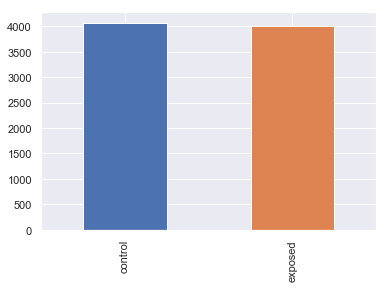

In [6]:
experiment.plot(kind='bar')

There are 4,071 control users and 4,006 users that were exposed to the actual advert. Also, I will like to know how long the collection of the data took by getting the min and max value of the dates.

In [7]:
#date range
x = datetime.strptime(df['date'].min(), "%Y-%M-%d")
y = datetime.strptime(df['date'].max(), "%Y-%M-%d")

In [8]:
date_range = y - x
print(date_range)

7 days, 0:00:00


Apparently, the data collection took seven days...interesting fact! Next on, I will be getting a visual representation of the phone brand of the users.

In [9]:
phone = df['device_make'].value_counts()
len(phone)

270

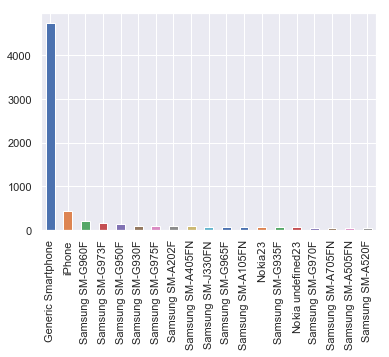

In [10]:
phone[phone > 50].plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Most of the participants uses Samsung while a majority of them uses a Generic Smartphone. This is a good point to note as well as we can put that into consideration when building a Machine Learning Algorithm for the hypothesis.

In [11]:
df['platform_os'].nunique()   #there are three operating for all the participants.

3

In [13]:
os = df['platform_os'].value_counts()

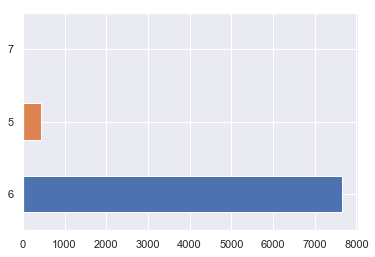

In [14]:
os.plot(kind='barh')

An overwhelming number of the participants uses an operating system with id 6. We might as well get familiar with the OS to ensure that there is no effect it can have on the response of the users.

In [15]:
df['yes'].value_counts()

0    7505
1     572
Name: yes, dtype: int64

Of all the participants, only 572 responded with a "yes" to the questionnaire inquiry that they know the brand. To further understand this distribution, I will sieve for what number of this group actually belong to the "exposed group"

In [16]:
yes = df[df['yes'] == 1]
len(yes[yes['experiment'] == 'exposed'])

308

Out of the 507 yeses, only 308 of it belongs to the "exposed" group. Interesting point to note as we are only interested in those that see the actual ad and from there became aware of the brand.

#### Respondents

Obtaining the number of participants that actually responded to the questionnaire i.e. chose wither yes or no. 

In [17]:
len(df[(df['yes'] == 1) | (df['no'] == 1)])

1243

Only 1,243 of the respondents responded to the questionnaire and this are the groups I are interested in for my A/B testing. 

## A/B Testing

**Null Hypothesis: The advert does not result in Users becoming aware of the brand.** I will perform A/B Testing to either accept or reject the hypothesis.

I will be sieving the data for those that responded to the questionnaire to start off

In [19]:
df_1 = df[(df['yes'] == 1) | (df['no'] == 1)]
df_1.reset_index(drop=True, inplace=True)
df_1.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
4,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


Performing sanity check through the invariant metrics:
* Fraction of participants that responded
* Fraction of participant with os 6 (since it's the dominant os)
* Fraction of participant with Generic Smartphone (since it's the dominant make)

#### Fraction of of Participants that Responded



In [20]:
## for the control group
c_x = len(df_1[df_1['experiment'] == 'control'])
c_x

586

Since 586 responded for the control group, and the total number of control participants is 4071, we can calculate the fraction of those that responded.

In [21]:
control_participants = c_x / 4071
round(control_participants, 4)

0.1439

Getting the same parameter for the exposed group:

In [22]:
## for the exposed group
e_x = len(df_1[df_1['experiment'] == 'exposed'])
e_x

657

Since 657 responded for the exposed group, and the total number of control participants is 4006, we can calculate the fraction of those that responded.

In [23]:
exposed_participants = e_x / 4006
round(exposed_participants, 4)

0.164

Well enough, 0.1439 and 0.164 looks pretty close, but I have to confirm that the difference is not statistically significant. I expected that the fraction of the group that responded to the questionnaire to be the same (hence probability 0.5) and I can define a random variable with an easy to use distribution.



In [24]:
#Method for getting z-score

def get_z_score(alpha):
    return norm.ppf(alpha)

In [25]:
p = 0.5
alpha = 0.05

p_hat =  round(control_participants/(control_participants + exposed_participants), 4)  #confidenc interval
sd = mt.sqrt(p*(1-p)/(control_participants + exposed_participants))   #standard deviation

ME = round(get_z_score(1 - (alpha/2))*sd, 4)
print("The confidence interval is between ", p-ME, " and,", p+ME, " :Is", p_hat, "inside this range?")

The confidence interval is between  -1.266  and, 2.266  :Is 0.4674 inside this range?


The observed p value is inside the range which means that the difference in the fraction of the group that responded is expected.

#### Evaluation Metrics
* Fraction of the responded participants that are aware of the brand

I would expect that there should be a significant difference between the metric for the two groups unless I might have to reject the null hypothesis.

In [26]:
# control group

c_responded = df_1[df_1['experiment'] == 'control'].reset_index(drop=True)
c_responded.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
1,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
2,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
3,01985992-d70b-4258-a3a1-60ac5e17bce6,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
4,023458f7-122d-475f-9525-1b9a3cc7a033,control,2020-07-03,15,MRD-LX1,6,Facebook,0,1


In [27]:
c_xr = len(c_responded)

In [28]:
c_aware = c_responded[c_responded['yes'] == 1].reset_index(drop=True)
c_aware.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
1,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
2,0332a7f7-0336-4d48-96ad-75da00d916c0,control,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
3,03948b84-b5b1-4f26-81fc-e953218aef1a,control,2020-07-09,20,Samsung SM-G930F,6,Facebook,1,0
4,04b69bd8-4849-4489-adcf-08b96a265c40,control,2020-07-07,15,Generic Smartphone,6,Chrome Mobile,1,0


In [29]:
c_xa = len(c_aware)

In [30]:
##exposed _group

e_responded = df_1[df_1['experiment'] == 'exposed'].reset_index(drop=True)
e_responded.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
3,013e45cf-e388-46a4-9c5b-a34303613940,exposed,2020-07-10,2,Generic Smartphone,6,Chrome Mobile,0,1
4,01905bae-fc59-475e-b2b4-09b78163c961,exposed,2020-07-05,6,I3312,6,Chrome Mobile WebView,0,1


In [31]:
e_xr = len(e_responded)

In [32]:
e_aware = e_responded[e_responded['yes'] == 1].reset_index(drop=True)
e_aware.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
1,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
2,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0
3,03ee1780-1fa3-4bec-926c-d543a81a6653,exposed,2020-07-04,11,Samsung SM-G981B,6,Chrome Mobile WebView,1,0
4,046644f4-b30c-48f9-b069-f804a97b77d9,exposed,2020-07-05,2,Generic Smartphone,6,Chrome Mobile WebView,1,0


In [33]:
e_xa = len(e_aware)

#### "The Net Conversion"
This is the fraction of participants that responded that and that are aware of the brand.

In [34]:
c_fraction = c_xa/c_xr
e_fraction = e_xa/e_xr

pooled_fraction = (c_xa + e_xa)/(c_xr + c_xr)
sd_pooled_fraction =  mt.sqrt(pooled_fraction*(1-pooled_fraction)*(1/c_xr + 1/e_xr))

fraction_ME = round(get_z_score(1 - alpha/2)*sd_pooled_fraction, 4)
frac_diff = round(e_fraction - c_fraction, 4)

In [35]:
print('The change due to the experiment is', frac_diff*100, '%')
print('Confidence Interval: [', frac_diff - fraction_ME, ',', frac_diff + fraction_ME, ']')

print('The change is statistically significant if the CI does not include 0. In that case, it is practically significant if -0.01 is not in the CI as well')

The change due to the experiment is 1.83 %
Confidence Interval: [ -0.0374 , 0.074 ]
The change is statistically significant if the CI does not include 0. In that case, it is practically significant if -0.01 is not in the CI as well


Based on the result above, I will accept the null hypothesis.

## Machine Learning

To start with, I will drop any column with na values. Also, I will combine "yes" and "no" column such that it's a column that would have 1 for participant that is aware and 0 for participants that is not aware or did not respond.

In [60]:
df_2 = df[df['experiment'] == 'exposed']

df_2.head()   #revewing the data

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
8,004940f5-c642-417a-8fd2-c8e5d989f358,exposed,2020-07-04,0,Generic Smartphone,6,Chrome Mobile WebView,0,0
13,006b9c6e-5f5d-4385-a811-ff20a24b30ac,exposed,2020-07-06,8,Samsung SM-G973F,6,Chrome Mobile WebView,0,0


In [61]:
df_2.dropna(inplace=True)

C:\Users\OWNER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
df_2.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
8,004940f5-c642-417a-8fd2-c8e5d989f358,exposed,2020-07-04,0,Generic Smartphone,6,Chrome Mobile WebView,0,0
13,006b9c6e-5f5d-4385-a811-ff20a24b30ac,exposed,2020-07-06,8,Samsung SM-G973F,6,Chrome Mobile WebView,0,0


In [64]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_2.loc[:, df_2.columns != 'yes'], df_2['yes'], test_size=0.2)

In [65]:
# Converting strings to numbers
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

X_train['date'] = lb.fit_transform(X_train['date'])
X_test['date'] = lb.fit_transform(X_test['date'])

X_train['device_make'] = lb.fit_transform(X_train['device_make'])
X_test['device_make'] = lb.fit_transform(X_test['device_make'])

X_train['browser'] = lb.fit_transform(X_train['browser'])
X_test['browser'] = lb.fit_transform(X_test['browser'])

In [66]:
X_train.head()   #reviewing data

,auction_id,experiment,date,hour,device_make,platform_os,browser,no
6324,c9156307-22e4-43b3-b4be-5326510fe367,exposed,0,10,36,6,2,0
782,190b1b06-f790-4ad0-8969-a0d1b305fd75,exposed,2,7,36,6,1,0
3125,650fdd80-fff4-4592-bba1-5775d391c324,exposed,2,9,36,6,1,0
4681,9548afa8-0b90-4c2e-a533-64f2e618b621,exposed,1,15,123,6,2,0
5903,bb00dc33-5d71-4b8d-8d90-03274088c362,exposed,6,17,36,6,1,0


In [67]:
X_test.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,no
259,07a8e25b-4bca-494d-a6d1-b06c11ff5532,exposed,4,3,86,6,7,1
1490,30e41f84-7a60-4f19-b1c5-ad878a4c314f,exposed,1,2,13,6,1,0
5252,a6aae51d-86de-4c0f-b203-9937126fef86,exposed,4,12,86,6,2,0
2531,518e3182-f8f8-4265-a7eb-ec8f085aa52e,exposed,2,12,17,6,0,0
6853,d9864e52-40cc-4f7a-94e7-e914c3db3c4a,exposed,6,19,13,6,1,0


## Logistic regression: A baseline

In [68]:
# import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing

train_features = X_train[['date', 'device_make', 'browser', 'hour']]

# Initialize logistic regression model
log_model = linear_model.LogisticRegression()

# Train the model
log_model.fit(X = train_features ,
              y = y_train)

# linear_regression = sm.OLS(y_train, X_train)
# linear_regression = linear_regression.fit()

# Check trained model intercept
print(log_model.intercept_)

# Check trained model coefficients
print(log_model.coef_)

[-2.36018999]
[[-0.0699641   0.00127676 -0.04450725  0.01854603]]


C:\Users\OWNER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
#using the test data_set for prediction 
train_features_2 = X_test[[ 'date', 'device_make', 'browser', 'hour']]
preds = log_model.predict(X= train_features_2)

# Generate table of predictions vs actual
pd.crosstab(preds, y_test)

yes,0,1
row_0,,
0,750,52


The model predicts that if 802 participants are shown the advert, only 52 will be aware of the brand!

In [56]:
log_model.score(X = train_features_2 ,
                y = y_test)

0.926980198019802